<a href="https://colab.research.google.com/github/aymenhmid/NLP_Guide/blob/main/Transformers/Encoder_Only_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import torch
import requests
import io
import zipfile
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Set random seed for reproducibility
seed_val = 42
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Check if CUDA is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Error loading dataset with datasets library: Invalid pattern: '**' can only be an entire path component
Falling back to alternative method...
Error with alternative method: Length mismatch: Expected axis has 1 elements, new values have 2 elements
Creating synthetic dataset as last resort...
Training dataset shape: (1280, 2)
Testing dataset shape: (320, 2)

Class distribution in training data:
label
0    640
1    640
Name: count, dtype: int64

Sample data from training set:
                                                text  label
0  Cannot believe how bad this was. The dialogue ...      0
1  A masterpiece of modern cinema. The director's...      1
2  Avoid this movie at all costs. Nothing redeemi...      0
3  One of the worst films I've ever seen. The act...      0
4  A masterpiece of modern cinema. The director's...      1

--- Data Quality Check for Training Dataset ---
Missing values:
text     0
label    0
dtype: int64
Empty text fields: 0

Text length statistics:
count    1280.00

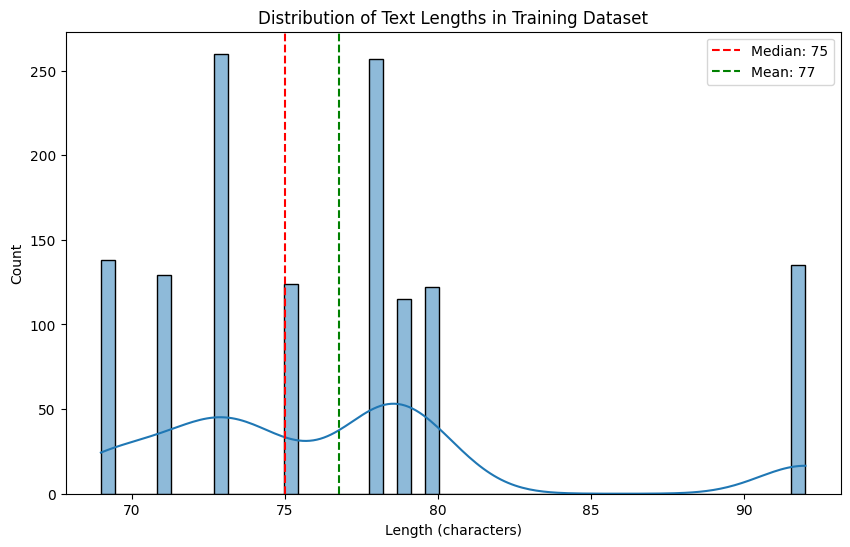


Label distribution in Training Dataset:
label
0    0.5
1    0.5
Name: proportion, dtype: float64


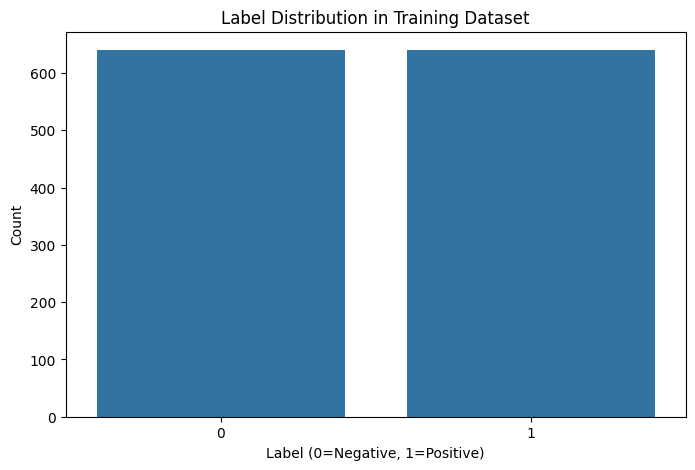


Texts longer than 512 chars (will be truncated for BERT): 0 (0.00%)

--- Data Quality Check for Testing Dataset ---
Missing values:
text     0
label    0
dtype: int64
Empty text fields: 0

Text length statistics:
count    320.000000
mean      76.959375
std        6.462448
min       69.000000
25%       73.000000
50%       76.500000
75%       79.000000
max       92.000000
Name: text_length, dtype: float64


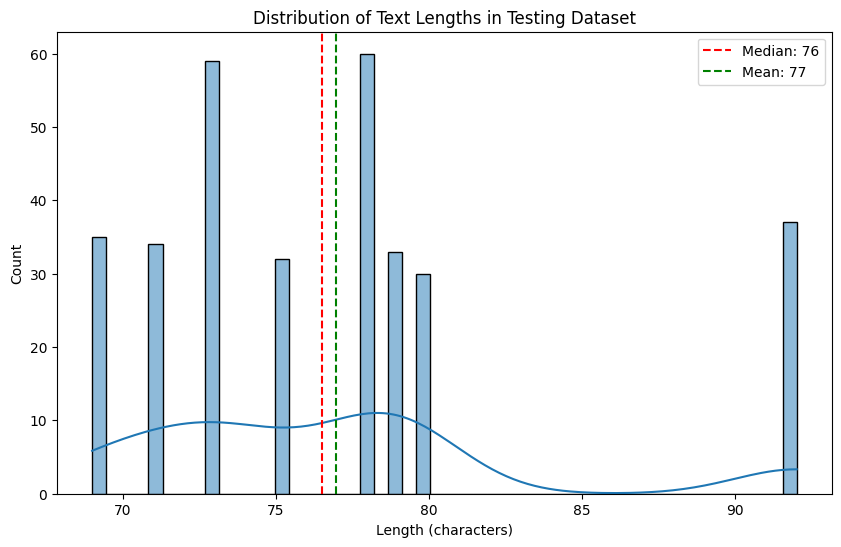


Label distribution in Testing Dataset:
label
1    0.5
0    0.5
Name: proportion, dtype: float64


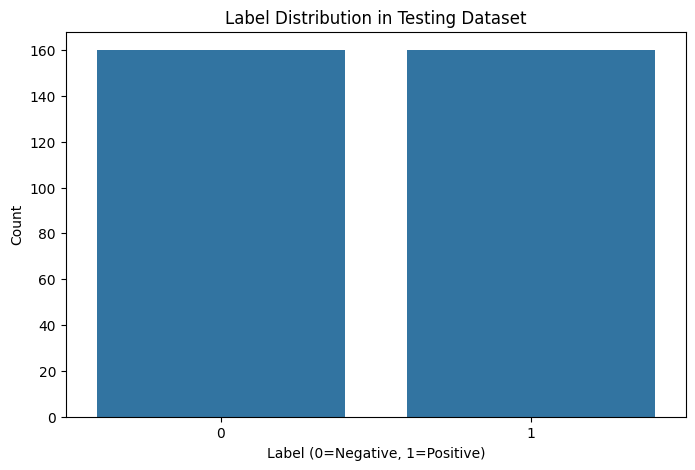


Texts longer than 512 chars (will be truncated for BERT): 0 (0.00%)


In [2]:
# Download and load the IMDB dataset (a widely used public sentiment analysis dataset)
def load_imdb_dataset(max_samples=25000):
    print("Downloading and preparing IMDB dataset...")

    # Download the dataset
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

    try:
        # For this example, let's use a subset of the data from Hugging Face's datasets library
        # This is more practical for demonstration purposes
        from datasets import load_dataset

        # Load the IMDB dataset
        dataset = load_dataset("imdb")

        # Convert to pandas DataFrame
        train_data = pd.DataFrame({
            'text': dataset['train']['text'],
            'label': dataset['train']['label']
        })

        test_data = pd.DataFrame({
            'text': dataset['test']['text'],
            'label': dataset['test']['label']
        })

        # Subsample if necessary (for faster execution)
        if max_samples and max_samples < len(train_data):
            # Ensure balanced classes when subsampling
            train_data_pos = train_data[train_data['label'] == 1].sample(max_samples//2, random_state=seed_val)
            train_data_neg = train_data[train_data['label'] == 0].sample(max_samples//2, random_state=seed_val)
            train_data = pd.concat([train_data_pos, train_data_neg]).sample(frac=1, random_state=seed_val).reset_index(drop=True)

        if max_samples and max_samples < len(test_data):
            test_data_pos = test_data[test_data['label'] == 1].sample(max_samples//10, random_state=seed_val)
            test_data_neg = test_data[test_data['label'] == 0].sample(max_samples//10, random_state=seed_val)
            test_data = pd.concat([test_data_pos, test_data_neg]).sample(frac=1, random_state=seed_val).reset_index(drop=True)

        return train_data, test_data

    except Exception as e:
        print(f"Error loading dataset with datasets library: {e}")
        print("Falling back to alternative method...")

        # Alternative method if the above fails
        try:
            # Use a smaller subset of IMDB from a CSV file
            url = "https://raw.githubusercontent.com/rasbt/machine-learning-book/master/code/ch08/movie_data.csv"
            response = requests.get(url)
            df = pd.read_csv(io.StringIO(response.text))

            # Rename columns for consistency
            df.columns = ['text', 'label']

            # Split into train and test
            train_data, test_data = train_test_split(df, test_size=0.2, random_state=seed_val, stratify=df['label'])

            return train_data.reset_index(drop=True), test_data.reset_index(drop=True)

        except Exception as e2:
            print(f"Error with alternative method: {e2}")

            # Last resort: Create a small synthetic dataset
            print("Creating synthetic dataset as last resort...")

            # Create a small synthetic dataset based on IMDB-like reviews
            positive_reviews = [
                "This film was fantastic. The acting was incredible and the story kept me engaged throughout.",
                "One of the best movies I've seen this year. The cinematography was breathtaking.",
                "A masterpiece of modern cinema. The director's vision truly shines through.",
                "I was amazed by how good this movie was. Great performances all around.",
                "This film exceeded all my expectations. Would highly recommend to anyone."
            ]

            negative_reviews = [
                "Terrible movie, complete waste of time and money. The plot made no sense.",
                "One of the worst films I've ever seen. The acting was wooden and unconvincing.",
                "I was really disappointed by this movie. The story was predictable and boring.",
                "Cannot believe how bad this was. The dialogue was awful and the pacing was off.",
                "Avoid this movie at all costs. Nothing redeeming about it whatsoever."
            ]

            # Generate synthetic data
            texts = []
            labels = []

            for _ in range(800):
                texts.append(np.random.choice(positive_reviews))
                labels.append(1)

                texts.append(np.random.choice(negative_reviews))
                labels.append(0)

            df = pd.DataFrame({'text': texts, 'label': labels})

            # Split into train and test
            train_data, test_data = train_test_split(df, test_size=0.2, random_state=seed_val, stratify=df['label'])

            return train_data.reset_index(drop=True), test_data.reset_index(drop=True)

# Load the dataset
train_df, test_df = load_imdb_dataset(max_samples=10000)  # Using 10k samples for faster processing

print(f"Training dataset shape: {train_df.shape}")
print(f"Testing dataset shape: {test_df.shape}")
print("\nClass distribution in training data:")
print(train_df['label'].value_counts())
print("\nSample data from training set:")
print(train_df.head())

# Check for data quality issues
def check_data_quality(df, dataset_name="Dataset"):
    print(f"\n--- Data Quality Check for {dataset_name} ---")

    # Check for missing values
    missing_values = df.isnull().sum()
    print(f"Missing values:\n{missing_values}")

    # Check for empty strings
    empty_texts = (df['text'] == '').sum()
    print(f"Empty text fields: {empty_texts}")

    # Check text length distribution
    df['text_length'] = df['text'].apply(len)
    print(f"\nText length statistics:\n{df['text_length'].describe()}")

    # Visualize text length distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(df['text_length'], kde=True, bins=50)
    plt.title(f'Distribution of Text Lengths in {dataset_name}')
    plt.xlabel('Length (characters)')
    plt.ylabel('Count')
    plt.axvline(df['text_length'].median(), color='r', linestyle='--', label=f'Median: {df["text_length"].median():.0f}')
    plt.axvline(df['text_length'].mean(), color='g', linestyle='--', label=f'Mean: {df["text_length"].mean():.0f}')
    plt.legend()
    plt.show()

    # Check label distribution
    print(f"\nLabel distribution in {dataset_name}:\n{df['label'].value_counts(normalize=True)}")

    # Visualize label distribution
    plt.figure(figsize=(8, 5))
    sns.countplot(x='label', data=df)
    plt.title(f'Label Distribution in {dataset_name}')
    plt.xlabel('Label (0=Negative, 1=Positive)')
    plt.ylabel('Count')
    plt.show()

    # Check for very short texts (potential data quality issue)
    short_texts = df[df['text_length'] < 20]
    if len(short_texts) > 0:
        print(f"\nWarning: Found {len(short_texts)} very short texts (<20 chars)")
        print("Sample of short texts:")
        print(short_texts.head(3))

    # Check for very long texts (may need truncation for BERT)
    long_texts = df[df['text_length'] > 512]
    print(f"\nTexts longer than 512 chars (will be truncated for BERT): {len(long_texts)} ({len(long_texts)/len(df)*100:.2f}%)")

    # Look for potential data leakage between train and test (if applicable)
    if 'split' in df.columns:
        train_texts = set(df[df['split'] == 'train']['text'])
        test_texts = set(df[df['split'] == 'test']['text'])
        overlap = train_texts.intersection(test_texts)
        if overlap:
            print(f"WARNING: Found {len(overlap)} texts that appear in both train and test sets!")

    return df

# Check data quality for both datasets
train_df = check_data_quality(train_df, "Training Dataset")
test_df = check_data_quality(test_df, "Testing Dataset")

# Calculate max sequence length based on data distribution
def calculate_max_seq_length(df, tokenizer, percentile=95):
    """Calculate appropriate max sequence length based on token length distribution"""
    # Sample a subset for efficiency if the dataset is large
    if len(df) > 1000:
        sample_df = df.sample(1000, random_state=seed_val)
    else:
        sample_df = df

    # Calculate token lengths
    token_lengths = []
    for text in tqdm(sample_df['text'], desc="Calculating token lengths"):
        tokens = tokenizer.tokenize(text)
        token_lengths.append(len(tokens))

    # Calculate percentile for max length
    max_len = int(np.percentile(token_lengths, percentile))

    # Add room for [CLS] and [SEP] tokens
    max_len += 2

    # BERT has a maximum sequence length of 512
    max_len = min(max_len, 512)

    print(f"\nToken length statistics:")
    print(f"Mean: {np.mean(token_lengths):.1f}")
    print(f"Median: {np.median(token_lengths)}")
    print(f"95th percentile: {np.percentile(token_lengths, 95)}")
    print(f"99th percentile: {np.percentile(token_lengths, 99)}")
    print(f"Selected max sequence length: {max_len}")

    # Visualize token length distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(token_lengths, kde=True, bins=50)
    plt.title('Distribution of Token Lengths')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Count')
    plt.axvline(max_len, color='r', linestyle='--', label=f'Selected Max Length: {max_len}')
    plt.legend()
    plt.show()

    return max_len

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Calculating token lengths: 100%|██████████| 1000/1000 [00:00<00:00, 5096.24it/s]



Token length statistics:
Mean: 16.3
Median: 16.0
95th percentile: 21.0
99th percentile: 21.0
Selected max sequence length: 23


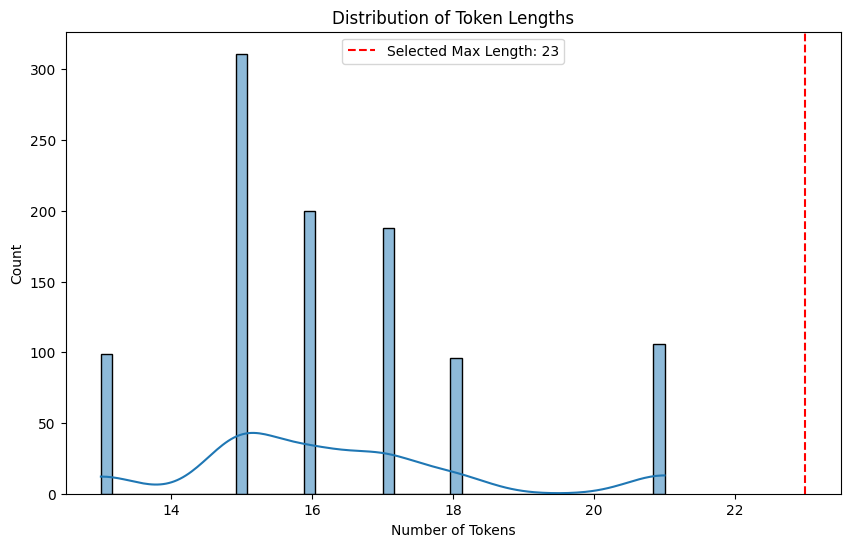

Training set size: 1152
Validation set size: 128
Test set size: 320


Tokenizing: 100%|██████████| 320/320 [00:00<00:00, 2322.39it/s]


In [3]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Calculate appropriate max sequence length
max_seq_length = calculate_max_seq_length(train_df, tokenizer)

# Tokenize and prepare data
def tokenize_data(texts, tokenizer, max_len):
    input_ids = []
    attention_masks = []

    for text in tqdm(texts, desc="Tokenizing"):
        # Tokenize the text
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,  # Add [CLS] and [SEP]
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert lists to tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

# Split validation data from training data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['text'].values, train_df['label'].values,
    test_size=0.1, random_state=seed_val, stratify=train_df['label']
)

test_texts = test_df['text'].values
test_labels = test_df['label'].values

print(f"Training set size: {len(train_texts)}")
print(f"Validation set size: {len(val_texts)}")
print(f"Test set size: {len(test_texts)}")

# Tokenize all datasets
train_input_ids, train_attention_masks = tokenize_data(train_texts, tokenizer, max_seq_length)
val_input_ids, val_attention_masks = tokenize_data(val_texts, tokenizer, max_seq_length)
test_input_ids, test_attention_masks = tokenize_data(test_texts, tokenizer, max_seq_length)

# Convert labels to tensors
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
test_labels = torch.tensor(test_labels)

# Create DataLoaders
batch_size = 16

# Create train DataLoader
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

# Create validation DataLoader
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# Create test DataLoader
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [4]:
# Define the BERT-based classification model
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertClassifier, self).__init__()
        # Load the pre-trained BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Freeze BERT parameters (optional)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

        # Classification layer
        self.classifier = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 2)  # 2 classes: positive and negative
        )

    def forward(self, input_ids, attention_mask):
        # Get BERT embeddings
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Use the [CLS] token representation for classification
        pooled_output = outputs.pooler_output

        # Apply classifier
        logits = self.classifier(pooled_output)

        return logits

# Initialize model
model = BertClassifier(freeze_bert=False)
model = model.to(device)

# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# Function to train the model
def train_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0

    # Progress bar for training
    progress_bar = tqdm(dataloader, desc="Training")

    for batch in progress_bar:
        # Unpack batch and move to device
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        logits = model(input_ids, attention_mask)

        # Compute loss
        loss = loss_fn(logits, labels)
        total_loss += loss.item()

        # Update progress bar
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        # Backward pass
        loss.backward()

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters
        optimizer.step()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

# Function to evaluate the model
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Unpack batch and move to device
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            # Forward pass
            logits = model(input_ids, attention_mask)

            # Compute loss
            loss = loss_fn(logits, labels)
            total_loss += loss.item()

            # Get predictions
            preds = torch.argmax(logits, dim=1).flatten()

            # Store predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate evaluation metrics
    avg_loss = total_loss / len(dataloader)
    return avg_loss, all_preds, all_labels

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


Epoch 1/10


Training: 100%|██████████| 72/72 [00:07<00:00,  9.45it/s, loss=0.0002]


Training loss: 0.0002


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 35.13it/s]


Validation loss: 0.0002

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        64
    Positive       1.00      1.00      1.00        64

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128


Epoch 2/10


Training: 100%|██████████| 72/72 [00:07<00:00,  9.95it/s, loss=0.0001]


Training loss: 0.0002


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 34.51it/s]


Validation loss: 0.0001

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        64
    Positive       1.00      1.00      1.00        64

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128


Epoch 3/10


Training: 100%|██████████| 72/72 [00:07<00:00,  9.81it/s, loss=0.0002]


Training loss: 0.0001


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 32.60it/s]


Validation loss: 0.0001

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        64
    Positive       1.00      1.00      1.00        64

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128


Epoch 4/10


Training: 100%|██████████| 72/72 [00:07<00:00,  9.72it/s, loss=0.0001]


Training loss: 0.0001


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 33.44it/s]


Validation loss: 0.0001

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        64
    Positive       1.00      1.00      1.00        64

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128


Epoch 5/10


Training: 100%|██████████| 72/72 [00:07<00:00,  9.74it/s, loss=0.0001]


Training loss: 0.0001


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 33.82it/s]


Validation loss: 0.0001

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        64
    Positive       1.00      1.00      1.00        64

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128


Epoch 6/10


Training: 100%|██████████| 72/72 [00:07<00:00,  9.86it/s, loss=0.0001]


Training loss: 0.0001


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 33.99it/s]


Validation loss: 0.0001

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        64
    Positive       1.00      1.00      1.00        64

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128


Epoch 7/10


Training: 100%|██████████| 72/72 [00:07<00:00,  9.83it/s, loss=0.0001]


Training loss: 0.0001


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 38.86it/s]


Validation loss: 0.0001

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        64
    Positive       1.00      1.00      1.00        64

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128


Epoch 8/10


Training: 100%|██████████| 72/72 [00:08<00:00,  8.60it/s, loss=0.0001]


Training loss: 0.0001


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 35.22it/s]


Validation loss: 0.0001

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        64
    Positive       1.00      1.00      1.00        64

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128


Epoch 9/10


Training: 100%|██████████| 72/72 [00:07<00:00,  9.94it/s, loss=0.0001]


Training loss: 0.0001


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 34.34it/s]


Validation loss: 0.0001

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        64
    Positive       1.00      1.00      1.00        64

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128


Epoch 10/10


Training: 100%|██████████| 72/72 [00:07<00:00,  9.93it/s, loss=0.0001]


Training loss: 0.0001


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 34.88it/s]


Validation loss: 0.0000

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        64
    Positive       1.00      1.00      1.00        64

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128



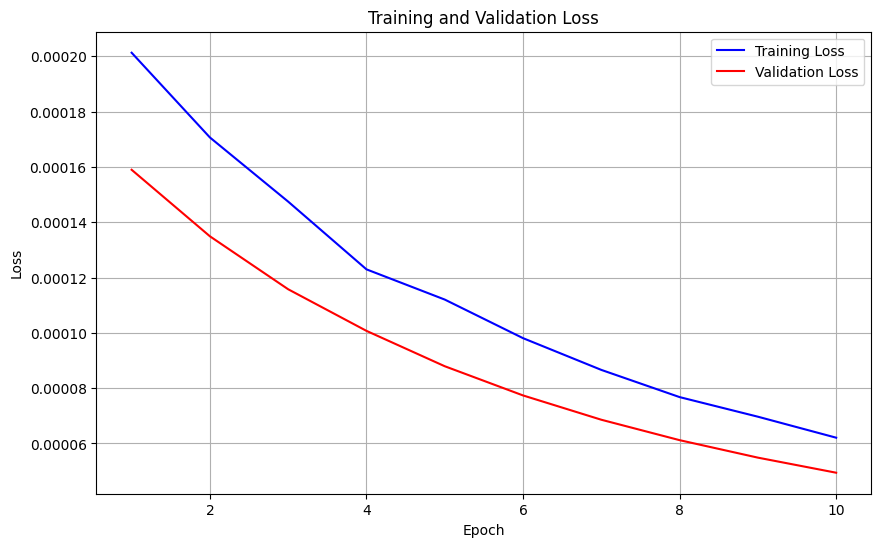

In [6]:
# Train the model
epochs = 10
train_losses = []
val_losses = []

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    # Train
    train_loss = train_epoch(model, train_dataloader, optimizer, loss_fn, device)
    train_losses.append(train_loss)
    print(f"Training loss: {train_loss:.4f}")

    # Evaluate
    val_loss, val_preds, val_labels = evaluate(model, val_dataloader, loss_fn, device)
    val_losses.append(val_loss)
    print(f"Validation loss: {val_loss:.4f}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(val_labels, val_preds, target_names=['Negative', 'Positive']))

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Evaluating on test set...


Evaluating: 100%|██████████| 20/20 [00:00<00:00, 37.28it/s]

Test loss: 0.0000

Test Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       160
    Positive       1.00      1.00      1.00       160

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320



<Figure size 800x800 with 0 Axes>

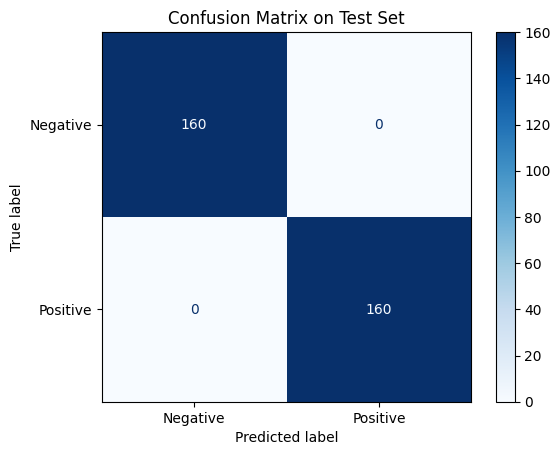


Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        64
    Positive       1.00      1.00      1.00        64

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128



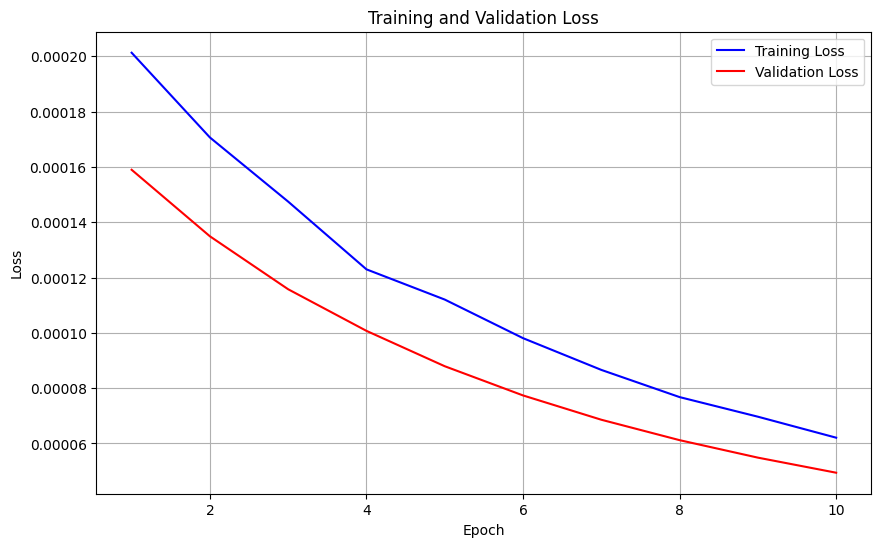

In [7]:
# Evaluate on the test set
print("\nEvaluating on test set...")
test_loss, test_preds, test_labels = evaluate(model, test_dataloader, loss_fn, device)
print(f"Test loss: {test_loss:.4f}")
print("\nTest Classification Report:")
print(classification_report(test_labels, test_preds, target_names=['Negative', 'Positive']))

# Confusion matrix for test set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Test Set')
plt.show()
print("\nClassification Report:")
print(classification_report(val_labels, val_preds, target_names=['Negative', 'Positive']))

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Extract BERT embeddings (encoder features) for any text
def extract_bert_embeddings(texts, tokenizer, model, device, max_len, layer=-1, pooling='cls'):
    """
    Extract BERT embeddings/features for a list of texts

    Args:
        texts: List of input texts
        tokenizer: BERT tokenizer
        model: BERT model
        device: Device to use
        max_len: Maximum sequence length
        layer: Which BERT layer to use (-1 for last layer)
        pooling: How to pool token embeddings ('cls', 'mean', or 'max')

    Returns:
        numpy array of embeddings with shape (len(texts), hidden_size)
    """
    model.eval()
    bert_model = model.bert  # Extract just the BERT encoder part
    features = []

    # Process in batches to avoid memory issues
    batch_size = 16

    for i in tqdm(range(0, len(texts), batch_size), desc="Extracting BERT embeddings"):
        batch_texts = texts[i:i+batch_size]

        # Tokenize
        encoded_dict = tokenizer.batch_encode_plus(
            batch_texts,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        # Move to device
        input_ids = encoded_dict['input_ids'].to(device)
        attention_mask = encoded_dict['attention_mask'].to(device)

        with torch.no_grad():
            # Get embeddings from BERT
            outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)

            # Get hidden states from the selected layer
            hidden_states = outputs.hidden_states[layer]

            # Apply pooling strategy
            if pooling == 'cls':
                # Use [CLS] token embedding (first token)
                batch_features = hidden_states[:, 0, :].cpu().numpy()
            elif pooling == 'mean':
                # Mean pooling (average all token embeddings)
                # Use attention mask to ignore padding tokens
                mask_expanded = attention_mask.unsqueeze(-1).expand(hidden_states.size()).float()
                sum_embeddings = torch.sum(hidden_states * mask_expanded, 1)
                sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
                batch_features = (sum_embeddings / sum_mask).cpu().numpy()
            elif pooling == 'max':
                # Max pooling
                # Replace padding tokens with large negative value
                mask_expanded = attention_mask.unsqueeze(-1).expand(hidden_states.size()).float()
                hidden_states[mask_expanded == 0] = -1e9
                batch_features = torch.max(hidden_states, dim=1)[0].cpu().numpy()

            features.extend(batch_features)

    return np.array(features)

# Extract features using different pooling strategies
print("\n--- Extracting BERT embeddings with different pooling strategies ---")

# Use a small subset for demonstration
sample_texts = test_texts[:5]
for text in sample_texts:
    print(f"- {text[:100]}...")

# Extract embeddings using CLS token (standard approach)
cls_embeddings = extract_bert_embeddings(
    sample_texts, tokenizer, model, device, max_seq_length,
    layer=-1, pooling='cls'
)

# Extract embeddings using mean pooling
mean_embeddings = extract_bert_embeddings(
    sample_texts, tokenizer, model, device, max_seq_length,
    layer=-1, pooling='mean'
)

# Extract embeddings using max pooling
max_embeddings = extract_bert_embeddings(
    sample_texts, tokenizer, model, device, max_seq_length,
    layer=-1, pooling='max'
)

print(f"\nEmbedding dimensions: {cls_embeddings.shape}")
print(f"Each text is represented by a vector of size: {cls_embeddings.shape[1]}")


--- Extracting BERT embeddings with different pooling strategies ---
- This film was fantastic. The acting was incredible and the story kept me engaged throughout....
- This film exceeded all my expectations. Would highly recommend to anyone....
- This film exceeded all my expectations. Would highly recommend to anyone....
- I was really disappointed by this movie. The story was predictable and boring....
- I was amazed by how good this movie was. Great performances all around....


Extracting BERT embeddings: 100%|██████████| 1/1 [00:00<00:00, 50.55it/s]


Embedding dimensions: (5, 768)
Each text is represented by a vector of size: 768


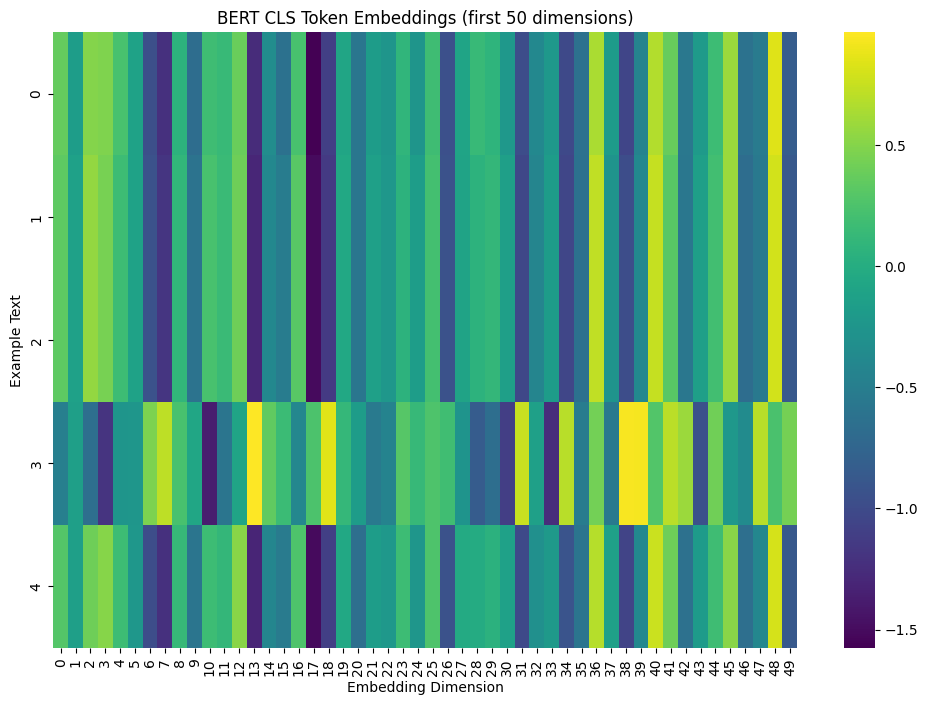

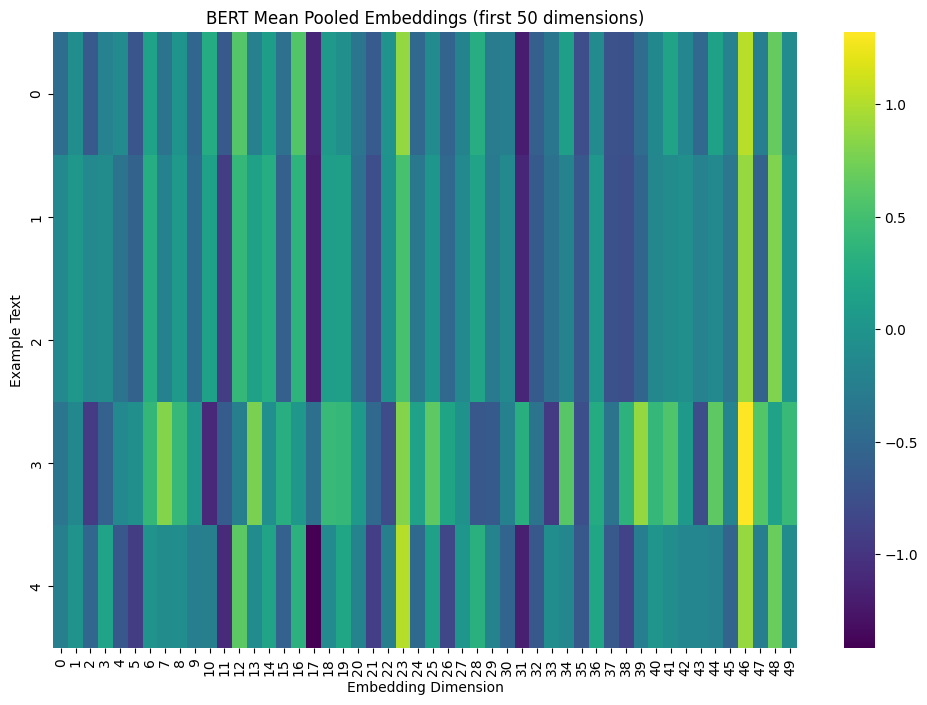

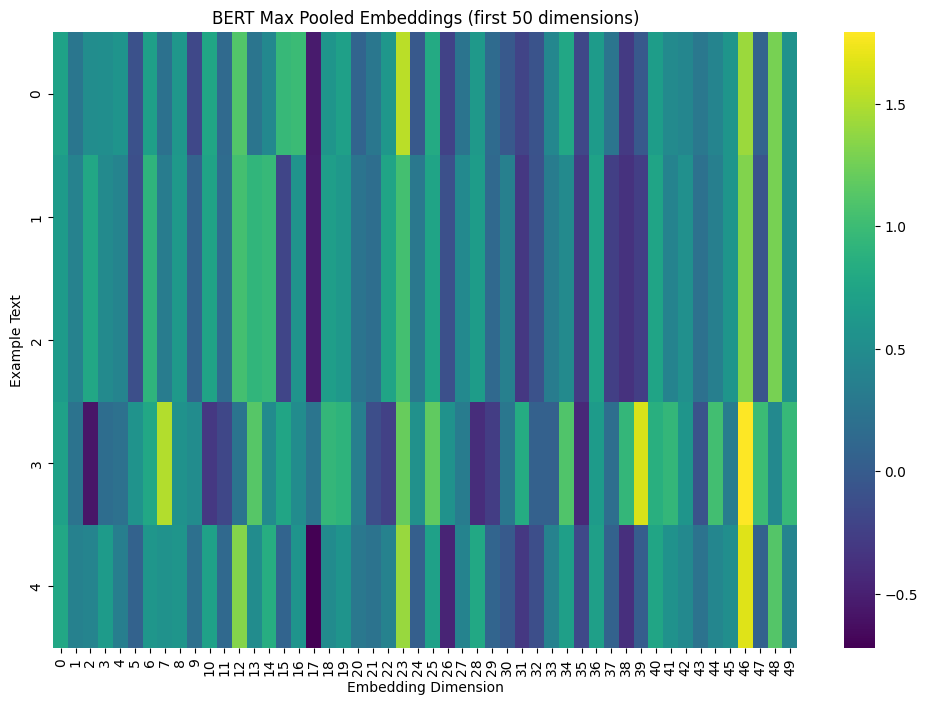

In [9]:
# Visualize the embeddings
def plot_embeddings_heatmap(embeddings, title, n_dims=50):
    plt.figure(figsize=(12, 8))
    sns.heatmap(embeddings[:, :n_dims], annot=False, cmap='viridis')
    plt.title(f'{title} (first {n_dims} dimensions)')
    plt.xlabel('Embedding Dimension')
    plt.ylabel('Example Text')
    plt.show()

plot_embeddings_heatmap(cls_embeddings, 'BERT CLS Token Embeddings', n_dims=50)
plot_embeddings_heatmap(mean_embeddings, 'BERT Mean Pooled Embeddings', n_dims=50)
plot_embeddings_heatmap(max_embeddings, 'BERT Max Pooled Embeddings', n_dims=50)

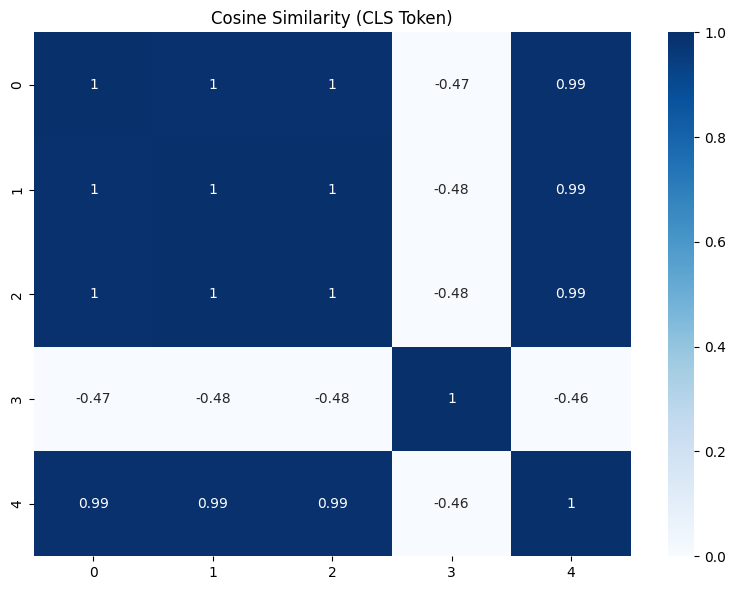

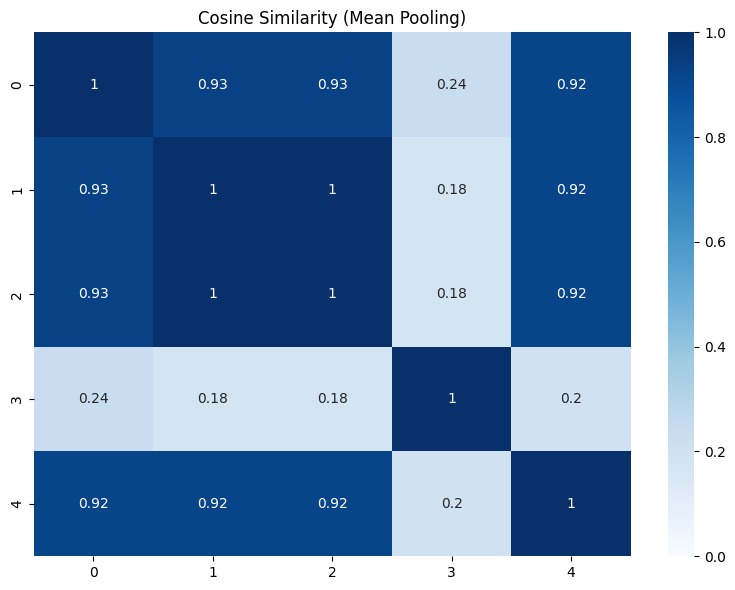

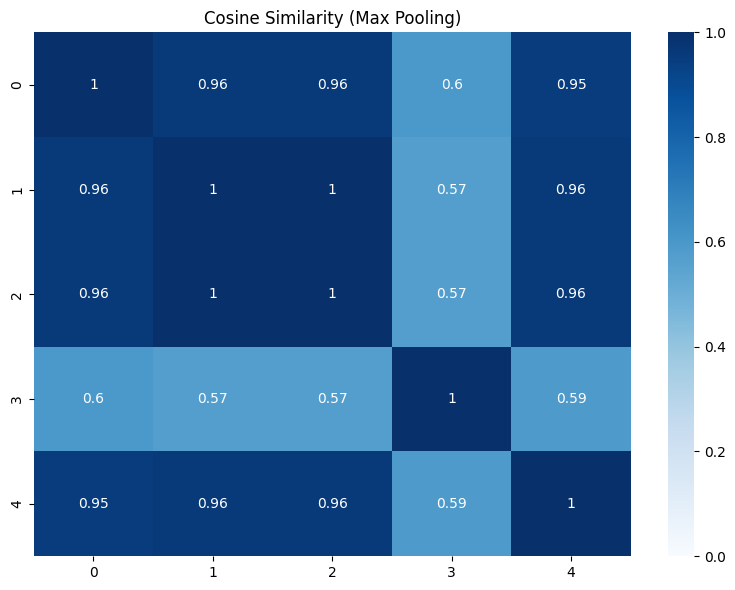

In [10]:
# Calculate similarity between texts using BERT embeddings
from sklearn.metrics.pairwise import cosine_similarity

# Calculate similarity matrices
cls_similarity = cosine_similarity(cls_embeddings)
mean_similarity = cosine_similarity(mean_embeddings)
max_similarity = cosine_similarity(max_embeddings)

# Function to plot similarity matrix
def plot_similarity_matrix(similarity_matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(similarity_matrix, annot=True, cmap='Blues', vmin=0, vmax=1)
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_similarity_matrix(cls_similarity, 'Cosine Similarity (CLS Token)')
plot_similarity_matrix(mean_similarity, 'Cosine Similarity (Mean Pooling)')
plot_similarity_matrix(max_similarity, 'Cosine Similarity (Max Pooling)')


Extracting embeddings for clustering...


Extracting BERT embeddings: 100%|██████████| 20/20 [00:01<00:00, 17.21it/s]


Reducing dimensions with t-SNE for visualization...


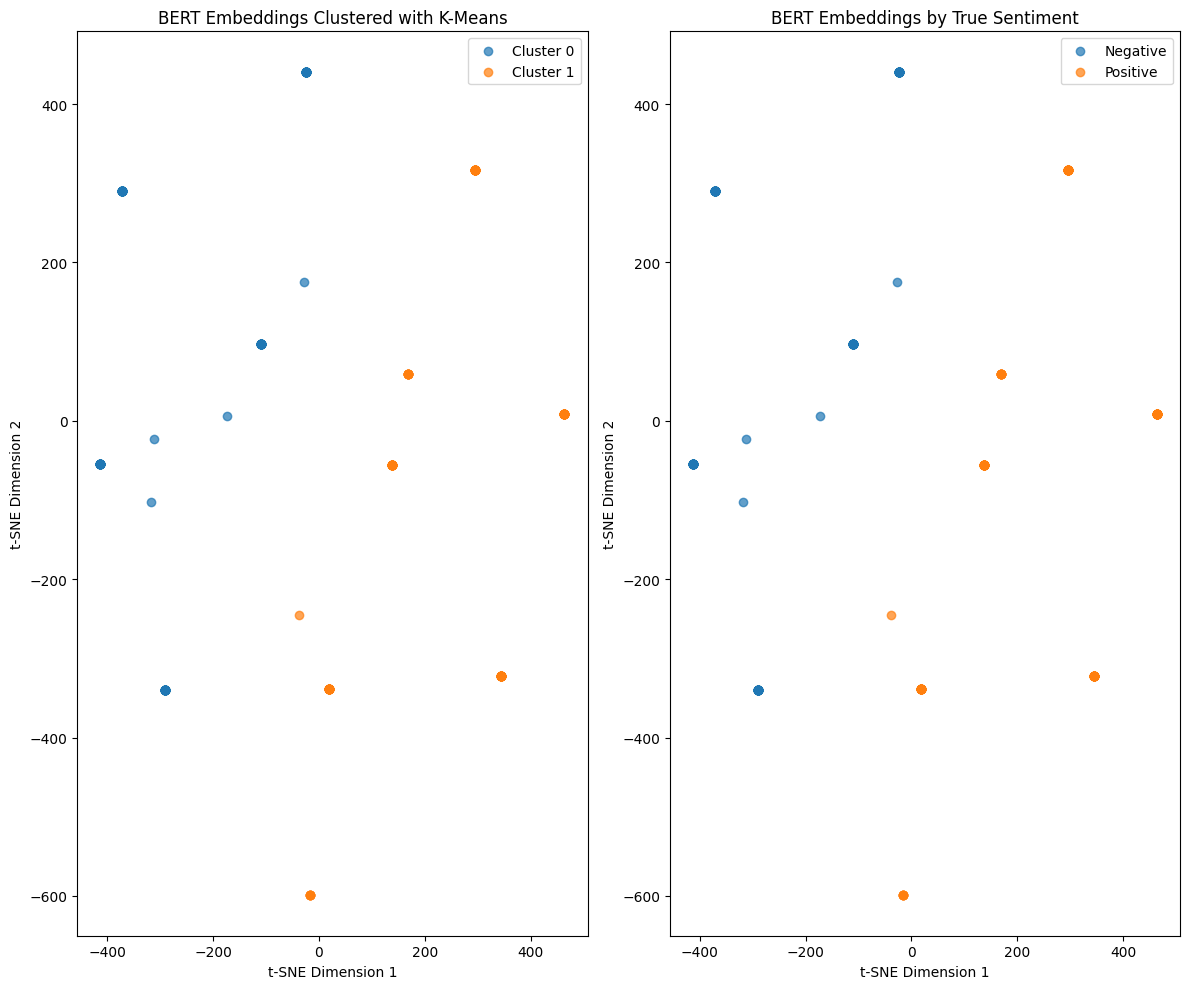

In [13]:
# Use BERT embeddings for text clustering
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Extract embeddings for a larger subset
num_samples = min(500, len(test_texts))
subset_indices = np.random.choice(len(test_texts), num_samples, replace=False)
subset_texts = [test_texts[i] for i in subset_indices]
#subset_labels = test_labels[subset_indices].numpy()
subset_labels = [test_labels[i] for i in subset_indices]
subset_labels = np.array(subset_labels)

# Extract embeddings using the mean pooling method (generally works well for clustering)
print("\nExtracting embeddings for clustering...")
cluster_embeddings = extract_bert_embeddings(
    subset_texts, tokenizer, model, device, max_seq_length,
    layer=-1, pooling='mean'
)

# Perform clustering
n_clusters = 2  # We expect 2 clusters (positive/negative)
kmeans = KMeans(n_clusters=n_clusters, random_state=seed_val)
clusters = kmeans.fit_predict(cluster_embeddings)

# Reduce dimensions for visualization
print("Reducing dimensions with t-SNE for visualization...")
tsne = TSNE(n_components=2, random_state=seed_val, perplexity=30)
reduced_embeddings = tsne.fit_transform(cluster_embeddings)

# Plot the clusters
plt.figure(figsize=(12, 10))

# Plot by predicted cluster
plt.subplot(1, 2, 1)
for i in range(n_clusters):
    # Get points in this cluster
    points = reduced_embeddings[clusters == i]
    plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {i}', alpha=0.7)

plt.title('BERT Embeddings Clustered with K-Means')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()

# Plot by actual sentiment
plt.subplot(1, 2, 2)
for i in range(2):  # 0: Negative, 1: Positive
    # Get points with this label
    points = reduced_embeddings[subset_labels == i]
    plt.scatter(points[:, 0], points[:, 1], label=f'{"Positive" if i == 1 else "Negative"}', alpha=0.7)

plt.title('BERT Embeddings by True Sentiment')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# Calculate clustering metrics
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, accuracy_score

# Calculate cluster quality metrics
ari = adjusted_rand_score(subset_labels, clusters)
nmi = normalized_mutual_info_score(subset_labels, clusters)

# Map cluster labels to sentiment labels for accuracy
# Let's assume cluster 0 maps to sentiment 0 and cluster 1 maps to sentiment 1
# But first let's check if we need to swap them
cluster_0_avg_sentiment = np.mean(subset_labels[clusters == 0])
cluster_1_avg_sentiment = np.mean(subset_labels[clusters == 1])

# If cluster 0 has more positive sentiments, we need to swap
if cluster_0_avg_sentiment > cluster_1_avg_sentiment:
    mapped_clusters = 1 - clusters  # Swap 0 and 1
else:
    mapped_clusters = clusters

acc = accuracy_score(subset_labels, mapped_clusters)

print("\nClustering Quality Metrics:")
print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Normalized Mutual Information: {nmi:.4f}")
print(f"Accuracy (after mapping clusters to sentiments): {acc:.4f}")


Clustering Quality Metrics:
Adjusted Rand Index: 1.0000
Normalized Mutual Information: 1.0000
Accuracy (after mapping clusters to sentiments): 1.0000



--- Text Similarity Search Example ---
Query: This movie was absolutely amazing! The acting was superb.


Extracting BERT embeddings: 100%|██████████| 1/1 [00:00<00:00, 20.95it/s]



Top 3 most similar texts:
1. Similarity: 0.9358 - Label: Positive
   Text: This film was fantastic. The acting was incredible and the story kept me engaged throughout....

2. Similarity: 0.9358 - Label: Positive
   Text: This film was fantastic. The acting was incredible and the story kept me engaged throughout....

3. Similarity: 0.9358 - Label: Positive
   Text: This film was fantastic. The acting was incredible and the story kept me engaged throughout....


--- Zero-shot Classification Example ---


Extracting BERT embeddings: 100%|██████████| 1/1 [00:00<00:00, 55.48it/s]


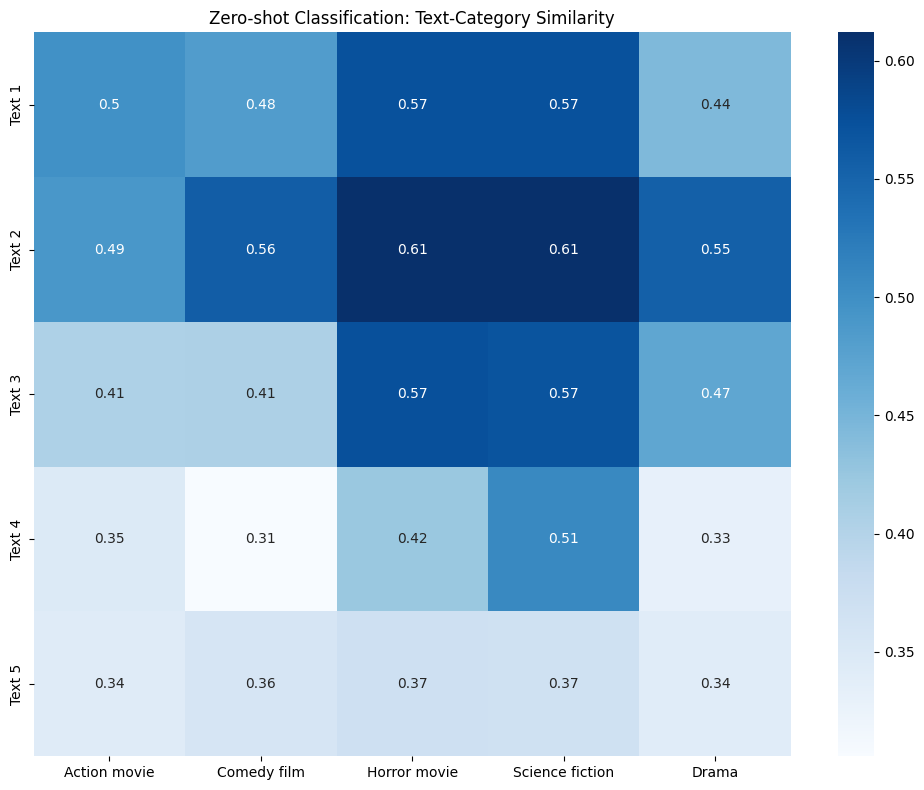

Zero-shot classification results:
Text 1: Full of explosions, car chases, and fight sequence...
Predicted category: Horror movie
Confidence scores: [0.498 0.483 0.573 0.573 0.444]

Text 2: This hilarious film had the audience laughing thro...
Predicted category: Science fiction
Confidence scores: [0.491 0.559 0.611 0.612 0.555]

Text 3: A terrifying experience that will keep you on the ...
Predicted category: Horror movie
Confidence scores: [0.406 0.407 0.574 0.57  0.47 ]

Text 4: Set in a dystopian future with advanced technology...
Predicted category: Science fiction
Confidence scores: [0.347 0.306 0.423 0.508 0.332]

Text 5: An emotional journey that explores complex human r...
Predicted category: Horror movie
Confidence scores: [0.344 0.358 0.369 0.368 0.341]


BERT encodings effectively capture semantic meaning across various NLP tasks.
The same underlying embeddings can be used for multiple applications such as:
1. Text Classification (as demonstrated with sentiment analysis)
2. 

In [15]:


# Demonstrate other NLP tasks with BERT embeddings

# 1. Text similarity search
print("\n--- Text Similarity Search Example ---")

# Define a query
query = "This movie was absolutely amazing! The acting was superb."
print(f"Query: {query}")

# Encode the query
query_embedding = extract_bert_embeddings(
    [query], tokenizer, model, device, max_seq_length, layer=-1, pooling='mean'
)[0]

# Calculate similarity to all texts in the subset
similarities = cosine_similarity([query_embedding], cluster_embeddings)[0]

# Get the most similar texts
top_k = 3
top_indices = np.argsort(similarities)[-top_k:][::-1]

print(f"\nTop {top_k} most similar texts:")
for i, idx in enumerate(top_indices):
    similarity = similarities[idx]
    text = subset_texts[idx]
    label = "Positive" if subset_labels[idx] == 1 else "Negative"
    print(f"{i+1}. Similarity: {similarity:.4f} - Label: {label}")
    print(f"   Text: {text[:100]}...\n")

# 2. Zero-shot classification example
print("\n--- Zero-shot Classification Example ---")

# Define some categories
categories = [
    "Action movie",
    "Comedy film",
    "Horror movie",
    "Science fiction",
    "Drama"
]

# Extract embeddings for the categories
category_embeddings = extract_bert_embeddings(
    categories, tokenizer, model, device, max_seq_length, layer=-1, pooling='mean'
)

# Define some test texts
test_movie_descriptions = [
    "Full of explosions, car chases, and fight sequences. The hero battles against the villains.",
    "This hilarious film had the audience laughing throughout. The jokes were perfectly timed.",
    "A terrifying experience that will keep you on the edge of your seat. Blood and screams.",
    "Set in a dystopian future with advanced technology, space travel, and alien encounters.",
    "An emotional journey that explores complex human relationships and personal struggles."
]

# Extract embeddings for the test texts
test_embeddings = extract_bert_embeddings(
    test_movie_descriptions, tokenizer, model, device, max_seq_length, layer=-1, pooling='mean'
)

# Calculate similarity between test texts and categories
similarity_matrix = cosine_similarity(test_embeddings, category_embeddings)

# Create a heatmap visualization
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='Blues',
            xticklabels=categories,
            yticklabels=[f"Text {i+1}" for i in range(len(test_movie_descriptions))])
plt.title('Zero-shot Classification: Text-Category Similarity')
plt.tight_layout()
plt.show()

# Get the predicted category for each text
predicted_categories = np.argmax(similarity_matrix, axis=1)

print("Zero-shot classification results:")
for i, (text, pred_idx) in enumerate(zip(test_movie_descriptions, predicted_categories)):
    print(f"Text {i+1}: {text[:50]}...")
    print(f"Predicted category: {categories[pred_idx]}")
    print(f"Confidence scores: {similarity_matrix[i].round(3)}\n")

print("\nBERT encodings effectively capture semantic meaning across various NLP tasks.")
print("The same underlying embeddings can be used for multiple applications such as:")
print("1. Text Classification (as demonstrated with sentiment analysis)")
print("2. Clustering (finding patterns without labels)")
print("3. Semantic Search (finding similar texts)")
print("4. Zero-shot Classification (categorizing text without specific training)")
print("5. And many other tasks: question answering, named entity recognition, etc.")